*This notebook was created by Sergey Tomin (sergey.tomin@desy.de) and [Igor Zagorodnov](http://www.desy.de/~zagor/) for Workshop: [Designing future X-ray FELs](http://www.xrayfels.co.uk/). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). Updated September 2020.*

# Tutorial N4.  Wakefields.

* Wake table format
* Wakefields of a Beam near a Single Plate in a Flat Dechirper
* Crosscheck with analytics: Dipole kick

## Chirper.
Influence of corrugated structure on the electron beam.
This example based on the work: [I. Zagorodnov, G. Feng, T. Limberg. Corrugated structure insertion for extending the SASE bandwidth up to 3% at the European XFEL](https://arxiv.org/abs/1607.07642). 

Gerometry of the corrugated structure. The blue ellipse represents an electron beam
propagating along the z axis.

<img src="4_corrugated_str.png" />

## Wakefields
In order to take into account the impact of the wake field on the beam the longitudinal wake function
of point charge through the second order Taylor expansion is used.
In general case it uses 13 one-dimensional functions to represent the  longitudinal component of the wake
function for arbitrary sets of the source and the wittness particles near to the reference axis.
The wake field impact on the beam is included as series of kicks.

The implementation of the wakefields follows closely the approach described 
in:
* [O. Zagorodnova, T. Limberg, Impedance budget database for the European XFEL,
in Proceedings of 2009 Particle Accelerator Conference,(Vancouver, Canada, 2009)](http://bib-pubdb1.desy.de/record/93956/files/tu5rfp060%5B1%5D.pdf)
* [M. Dohlus, K. Floettmann, C. Henning, Fast particle tracking with wake 
fields, Report No. DESY 12-012, 2012.](https://arxiv.org/abs/1201.5270)

#### This example will cover the following topics:
* Initialization of the wakes and the places of their applying
* tracking of second order with wakes

#### Requirements 
* beam_chirper.ast    - input file, initial beam distribution in [ASTRA](http://www.desy.de/~mpyflo/) format (was obtained from s2e simulation performed with ASTRA and [CSRtrack](http://www.desy.de/fel-beam/psviewer/index.html)).
* wake_vert_1m.txt - wake table of the vertical corrugated structure (was calculated with [ECHO](http://www.desy.de/~zagor/WakefieldCode_ECHOz/))
* wake_hor_1m.txt - wake table of the vertical corrugated structure (was calculated with [ECHO](http://www.desy.de/~zagor/WakefieldCode_ECHOz/))

## Wake Table format

We use the same format of the wakes as implemented in ASTRA and the description of the format can be found in [M. Dohlus, K. Floettmann, C. Henning, Fast particle tracking with wake 
fields, Report No. DESY 12-012, 2012.](https://arxiv.org/abs/1201.5270)

Second order Taylor expansion of the longitudinal wake ($w_z$) in the transverse coordinates

$$
w_z(x_s, y_s, x_o, y_o, s) = 
\begin{bmatrix}
    1 \\
    x_s\\
    y_s\\
    x_o \\
    y_o
\end{bmatrix}^T 
\begin{bmatrix}
     h_{00}(s) & h_{01}(s) & h_{02}(s) & h_{03}(s) & h_{04}(s) \\
     0   &       h_{11}(s) & h_{12}(s) & h_{13}(s) & h_{14}(s)\\
     0   &       h_{12}(s) & -h_{11}(s) & h_{23}(s) & h_{24}(s) \\
     0   &       h_{13}(s) & h_{23}(s) & h_{33}(s) & h_{34}(s)\\
     0   &       h_{14}(s) & h_{24}(s) & h_{34}(s) & -h_{33}(s)
\end{bmatrix} 
\begin{bmatrix}
    1 \\
    x_s\\
    y_s\\
    x_o \\
    y_o
\end{bmatrix} ;
$$
where $x_s$ and $y_s$ transverse coordinates of the *source* particle and $x_o$ and $y_o$ are transverse coordinates of the *observer*, $s$ is distance between *source* and *observer*. Thus to describe longitudinal wake we need 13 functions $h_{\alpha \beta}$. 

The transverse components are uniquely related to the longitudinal wake by causality and Panofsky-Wenzel-Theorem.

For each of these coefficients, we use the representation in [O. Zagorodnova, T. Limberg, Impedance budget database for the European XFEL](http://bib-pubdb1.desy.de/record/93956/files/tu5rfp060%5B1%5D.pdf) 
\begin{equation}
h(s) = w_0(s) + \frac{1}{C} + R c\delta(s) + c\frac{\partial}{\partial s}\left[L c \delta(s) + w_1 (s) \right]
\end{equation}
where $w_0(s)$, $w_1(s)$ are nonsingular functions, which can be tabulated easily, and constants $R$, $L$, and $C$ have the meaning of resistivity, inductance, and capacitance, correspondingly.
The functions $w_0(s)$, $w_1(s)$ can be represented by table, e.g. [$s_i$, $w_0^i$].

Now we can describe whole table how it is saved in a file. 

$N_h$| $0$ 
--------------|-----------------
 $N_{w_0}$    | $N_{w_1}$
 $R,\: [Us]$  | $L,\: [Us^2]$
$C,\: [1/Us]$ | $10\alpha + \beta$  
$s_1,\: [m]$  |  $w_0(s_1),\: [U]$ 
$s_2,\: [m]$  |$w_0(s_2),\: [U]$ 
 ...          |  ... 
$s_{N_{w_0}},\: [m]$ | $w_0(s_{N_{w_0}}),\: [U]$ 
$s_1,\: [m]$  |  $w_1(s_1),\: [U]$ 
$s_2,\: [m]$  |$w_1(s_2),\: [U]$ 
 ...          |  ... 
$s_{N_{w_1}},\: [m]$ | $w_1(s_{N_{w_1}}),\: [U]$
 $N_{w_0}$    | $N_{w_1}$
 $R,\: [Us]$  | $L,\: [Us^2]$
$C,\: [1/Us]$ | $10\alpha + \beta$  
$s_1,\: [m]$  |  $w_0(s_1),\: [U]$ 
 ...          |  ... 
  $N_{w_0}$    | $N_{w_1}$
 $R,\: [Us]$  | $L,\: [Us^2]$
$C,\: [1/Us]$ | $10\alpha + \beta$  
$s_1,\: [m]$  |  $w_0(s_1),\: [U]$ 
 ...          |  ... 



In the very first line, $N_h$ is number of $h_{\alpha\beta}(s)$ functions in the table. After that, a typical table repeated $N_h$ times describing every $h_{\alpha\beta}(s)$ function. 


Every table starts with $N_{w_0}$ and $N_{w_1}$ which are number of points of $w_0(s_i)$ and $w_1(s_i)$ functions.
Next two lines are included $R$, $L$, $C$ and  entry $10\alpha + \beta$ which describes the subscript of the auxiliary function $h_{\alpha\beta}(s)$. Next $N_{w_0}$ lines described function $w_0(s)$, and after that next $N_{w_1}$ lines described function $w_1(s)$.

And to describe next $h_{\alpha\beta}(s)$ we repeat procedure. 

The unit $U$ is $V/(A\cdot s)$ for $\alpha\beta = 00$, $V/(A\cdot s \cdot m)$ for $\alpha\beta = 01, ... 04$ and $V/(A\cdot s \cdot m^2)$ for all other coefficients.
 

### Import of modules

In [1]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it
%matplotlib inline

# this python library provides generic shallow (copy) and deep copy (deepcopy) operations 
from copy import deepcopy
import time

# import from Ocelot main modules and functions
from ocelot import *

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

initializing ocelot...


### Layout of the Corrugated Structure Insertion and Creation of the Ocelot Lattice

![png](4_layout.png)  
<p align="center"><em>Layout of the corrugated structure insertion</em></p>

In this section, we define the beamline using the [**MagneticLattice**](https://www.ocelot-collab.com/docs/docu/elements/magnet/) class and compute the Twiss parameters.

Relevant documentation:

- [**Twiss class**](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/twiss/)  
- [**twiss() function**](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/twiss/#from_seriescls-series-pdseries)

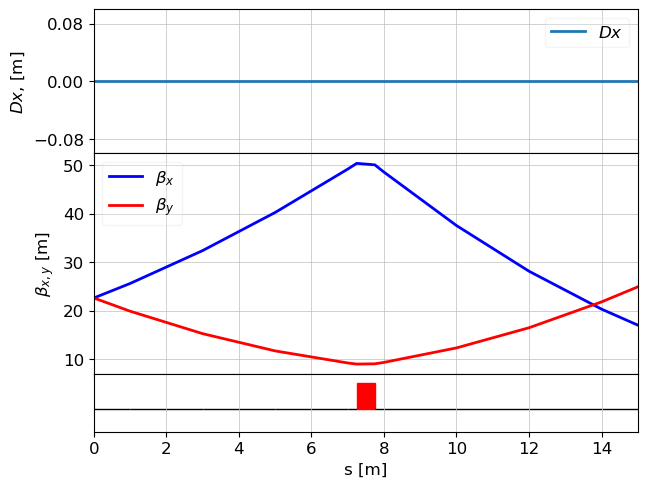

In [2]:
D00m25 = Drift(l = 0.25)
D01m = Drift(l = 1)
D02m = Drift(l = 2)

# Create markers for defining places of the wakes applying 
w1_start = Marker()
w1_stop = Marker()

w2_start = Marker()
w2_stop = Marker()

w3_start = Marker()
w3_stop = Marker()

w4_start = Marker()
w4_stop = Marker()

w5_start = Marker()
w5_stop = Marker()

w6_start = Marker()
w6_stop = Marker()
# quadrupoles
Q1 = Quadrupole(l = 0.5, k1 = 0.215)

# lattice
lattice = (D01m, w1_start, D02m, w1_stop, w2_start, D02m, w2_stop, 
           w3_start, D02m, w3_stop, D00m25, Q1, D00m25, 
           w4_start, D02m, w4_stop, w5_start, D02m, w5_stop, 
           w6_start, D02m, w6_stop, D01m)

# creation MagneticLattice
lat = MagneticLattice(lattice, method={"global": SecondTM})

# calculate twiss functions with initial twiss parameters
tws0 = Twiss()
tws0.E = 14  # in GeV
tws0.beta_x = 22.5995
tws0.beta_y = 22.5995
tws0.alpha_x = -1.4285
tws0.alpha_y = 1.4285
tws = twiss(lat, tws0, nPoints=None)
# ploting twiss paramentrs.
plot_opt_func(lat, tws, top_plot=["Dx"], fig_name="i1", legend=False)
plt.show()

## Load beam file

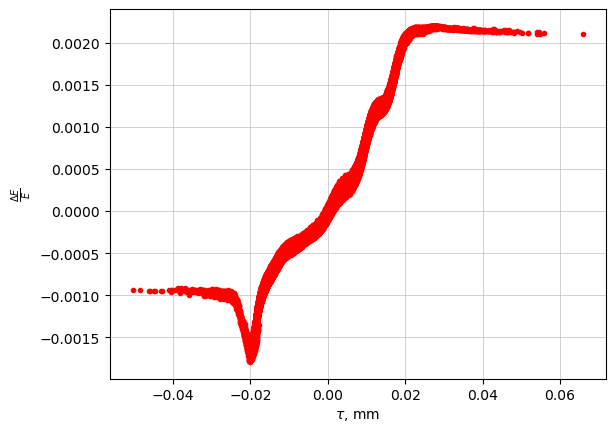

In [3]:
# load and convert ASTRA file to OCELOT beam distribution
# p_array_init = astraBeam2particleArray(filename='beam_chirper.ast')

# save ParticleArray to compresssed numpy array 
# save_particle_array("chirper_beam.npz", p_array_init)
p_array_init = load_particle_array("chirper_beam.npz")

plt.plot(-p_array_init.tau()*1000, p_array_init.p(), "r.")
plt.grid(True)
plt.xlabel(r"$\tau$, mm")
plt.ylabel(r"$\frac{\Delta E}{E}$")
plt.show()

## Initialization of Wakefields and Their Placement in the Lattice

More details about the `Wake` class can be found in the documentation:  
👉 [**Wake Class**](https://www.ocelot-collab.com/docs/docu/physics-processes/wake)


In [4]:
# load wake tables of corrugated structures
wk_vert = WakeTable('wake_vert_1m.txt')
wk_hor = WakeTable('wake_hor_1m.txt')

# creation of wake object with parameters 
wake_v1 = Wake()
# w_sampling - defines the number of the equidistant sampling points for the one-dimensional
# wake coefficients in the Taylor expansion of the 3D wake function.
wake_v1.w_sampling = 500
wake_v1.wake_table = wk_vert
wake_v1.step = 1 # step in Navigator.unit_step, dz = Navigator.unit_step * wake.step [m]

# Alternatively, all parameters can be set directly in the constructor: 
wake_h1 = Wake(step=1, w_sampling=500, wake_table=wk_hor)


wake_v2 = deepcopy(wake_v1) 

wake_h2 = deepcopy(wake_h1)

wake_v3 = deepcopy(wake_v1) 

wake_h3 = deepcopy(wake_h1)

## Adding Wakefields to the Lattice

The [**Navigator**](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/navigator) class defines the tracking step size (`dz`) and manages which physics processes are applied at each step.

To include any [**Physics Process**](https://www.ocelot-collab.com/docs/category/physics-processes/) (such as [**Space Charge**](https://www.ocelot-collab.com/docs/docu/physics-processes/sc), [**CSR**](https://www.ocelot-collab.com/docs/docu/physics-processes/csr), [**Wake**](https://www.ocelot-collab.com/docs/docu/physics-processes/wake/) and so on), you must use:

**Method:**

Navigator.add_physics_proc(physics_proc, elem1, elem2)

- `physics_proc`: an instance of a physics process (e.g. `Wake`, `SpaceCharge`, `CSR`)  
- `elem1`, `elem2`: the first and last lattice elements between which the process will be applied

### Step Size Control

You must also define the `unit_step` in meters (default is `1.0` m):
```python
navi.unit_step = 0.02  # for example, 2 cm step size
```
Each physics process is applied every `step` multiples of `unit_step`:
```
dz = unit_step x step
```
- The `step` attribute must be an integer.
- This allows you to control how frequently each effect is applied — for example, less frequently at higher energies to reduce computation time.

In [5]:
navi = Navigator(lat)

# add physics proccesses
navi.add_physics_proc(wake_v1, w1_start, w1_stop)
navi.add_physics_proc(wake_h1, w2_start, w2_stop)
navi.add_physics_proc(wake_v2, w3_start, w3_stop)
navi.add_physics_proc(wake_h2, w4_start, w4_stop)
navi.add_physics_proc(wake_v3, w5_start, w5_stop)
navi.add_physics_proc(wake_h3, w6_start, w6_stop)

# definiing unit step in [m]
navi.unit_step = 0.2 

# deep copy of the initial beam distribution 
p_array = deepcopy(p_array_init)
print("tracking with Wakes .... ")
start = time.time()
tws_track, p_array = track(lat, p_array, navi)
print("\n time exec:", time.time() - start, "sec")

tracking with Wakes .... 
z = 15.0 / 15.0. Applied: 5.0. Applied: Wake
 time exec: 1.6785151958465576 sec


## Longitudinal beam distribution

100000


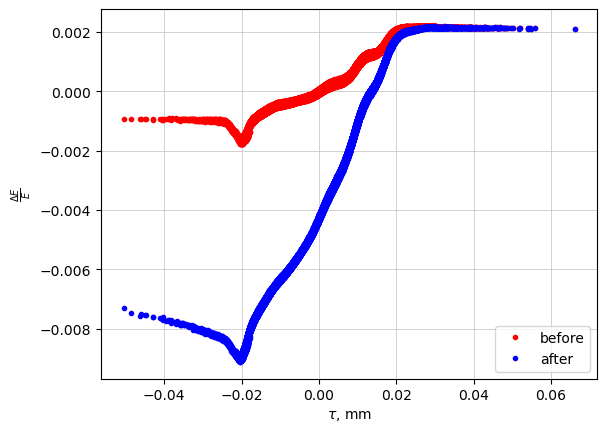

In [6]:
tau0 = p_array_init.tau()
p0 = p_array_init.p()

tau1 = p_array.tau()
p1 = p_array.p()
print(len(p1))
plt.figure(1)
plt.plot(-tau0*1000, p0, "r.", -tau1*1000, p1, "b.")
plt.legend(["before", "after"], loc=4)
plt.grid(True)
plt.xlabel(r"$\tau$, mm")
plt.ylabel(r"$\frac{\Delta E}{E}$")
plt.show()

### Beam distribution

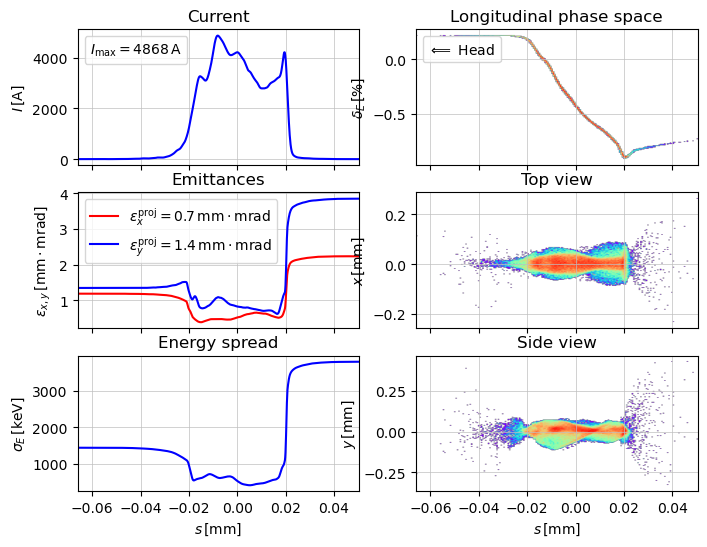

In [7]:
# by default the beam head on the left side
show_e_beam(p_array, figsize=(8,6))
plt.show()

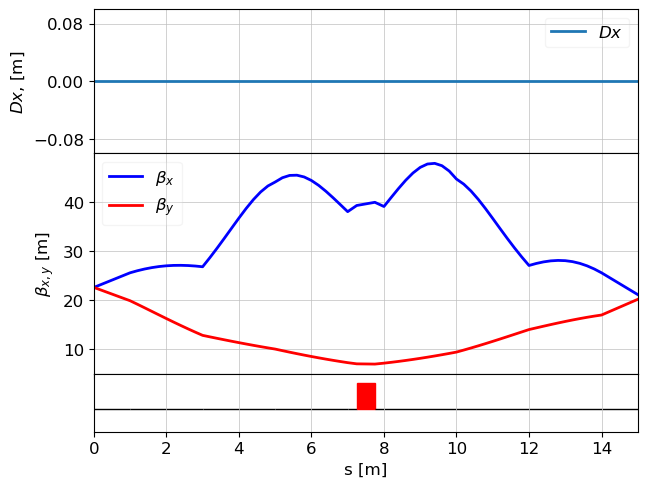

In [8]:
# plotting twiss parameters.
plot_opt_func(lat, tws_track, top_plot=["Dx"], fig_name="i1", legend=False)
plt.show()

## Wakefields of a Beam near a Single Plate in a Flat Dechirper

For some FEL applications, e.g. a two-color scheme, only one flat corrugated structure can be used to get a correlated transverse kick along the electron bunch. In that case, we can use analytical approach from [I. Zagorodnov, G. Feng, T. Limberg. Corrugated structure insertion for extending the SASE bandwidth up to 3% at the European XFEL](https://arxiv.org/abs/1607.07642) and [K. Bane, G. Stupakov, and I. Zagorodnov, Wakefields of a Beam near a Single Plate in a Flat Dechirper](https://www.slac.stanford.edu/cgi-wrap/getdoc/slac-pub-16881.pdf) to calculate described above the wakefield tables. 

<div class="alert alert-block alert-warning">
<b>Note:</b> Due to the use of assumptions in the analytical approach, a transverse kick is infinite if the electron beam distance to the plate wall is zero.  </div>

#### A small note about transverse modes
Let's look at the wakefield components. Let's start with the expression above:
$$
w_z(x_s, y_s, x_o, y_o, s) = 
\begin{bmatrix}
    1 \\
    x_s\\
    y_s\\
    x_o \\
    y_o
\end{bmatrix}^T 
\begin{bmatrix}
     h_{00}(s) & h_{01}(s) & h_{02}(s) & h_{03}(s) & h_{04}(s) \\
     0   &       h_{11}(s) & h_{12}(s) & h_{13}(s) & h_{14}(s)\\
     0   &       h_{12}(s) & -h_{11}(s) & h_{23}(s) & h_{24}(s) \\
     0   &       h_{13}(s) & h_{23}(s) & h_{33}(s) & h_{34}(s)\\
     0   &       h_{14}(s) & h_{24}(s) & h_{34}(s) & -h_{33}(s)
\end{bmatrix} 
\begin{bmatrix}
    1 \\
    x_s\\
    y_s\\
    x_o \\
    y_o
\end{bmatrix} ;
$$

Expand the result of the multiplication:
$$
w_z(x_s, y_s, x_o, y_o, s) = h_{00}(s) + h_{03}(s) x_o + h_{33}(s) x_o^2 + h_{01}(s) x_s + 2 h_{13}(s) x_o x_s + h_{11}(s) x_s^2 + h_{04}(s) y_o + 
 2 h_{34}(s) x_o y_o + 2 h_{14}(s) x_s y_o - h_{33}(s) y_o^2 + h_{02}(s) y_s + 2 h_{23}(s) x_o y_s + 
 2 h_{12}(s) x_s y_s + 2 h_{24}(s) y_o y_s - h_{11}(s) y_s^2
$$

Using Panofsky-Wenzel-Theorem the transverse components are:

$$
\frac{\partial}{\partial s}w_y(x_s, y_s, x_o, y_o, s) = -\frac{\partial}{\partial y_o}w_z(x_s, y_s, x_o, y_o, s) = -(h_{04}(s) + 2 h_{34}(s) x_o + 2 h_{14}(s) x_s - 2 h_{33}(s) y_o + 2 h_{24}(s) y_s)
$$
where $-h_{04}(s)$ monopole transverse component, $-h_{24}(s)$ - dipole component, $h_{33}(s)$ - quadrupole component, 


$$
\frac{\partial}{\partial s}w_x(x_s, y_s, x_o, y_o, s) = -\frac{\partial}{\partial x_o}w_z(x_s, y_s, x_o, y_o, s) = -(h_{03}(s) + 2 h_{33}(s) x_o + 2 h_{13}(s) x_s + 2 h_{34}(s) y_o + 2 h_{23}(s) y_s)
$$
where $h_{03}(s)$ - monopole transverse component, $-h_{13}(s)$ - dipole component, $-h_{33}(s)$ - quadrupole component. 


Integral forms:
$$
w_y(x_s, y_s, x_o, y_o, s) = - \int_{-\infty}^s{\frac{\partial}{\partial y_o}w_z(x_s, y_s, x_o, y_o, s') ds'}
$$
$$
w_x(x_s, y_s, x_o, y_o, s) = - \int_{-\infty}^s{\frac{\partial}{\partial x_o}w_z(x_s, y_s, x_o, y_o, s') ds'}
$$

In [9]:
# create a simple lattice MagneticLattice
m1 = Marker()
m2 = Marker()
# quadrupoles
Q1 = Quadrupole(l = 0.5, k1 = 0.215)

lattice = (Drift(l=1), m1, Drift(l=1), m2, Drift(l=2), Q1, Drift(l=2))

lat = MagneticLattice(lattice, method={"global": SecondTM})

### Describe corrugated structure and add wake to the lattice

In [10]:
# description of args can be also be shown with Shift+Tab 
sigma = np.std(p_array.tau())
print("RMS long beam size: ", sigma * 1e6, " um")
wk_tv_kick = WakeTableDechirperOffAxis(b=500*1e-6,    # distance from the plate in [m]
                                       a=0.01,        # half gap between plates in [m]
                                       width=0.02,    # width of the corrugated structure in [m]
                                       t=0.25*1e-3,   # longitudinal gap in [m]
                                       p=0.5*1e-3,    # period of corrugation in [m]
                                       length=1,      # length of the corrugated structure in [m]
                                       sigma=12e-6,   # characteristic (rms) longitudinal beam size in [m]
                                       orient="horz") # "horz" or "vert" plate orientation 

# creation of wake object with parameters 
wake = Wake()
# w_sampling - defines the number of the equidistant sampling points for the one-dimensional
# wake coefficients in the Taylor expansion of the 3D wake function.
wake.w_sampling = 500
wake.wake_table = wk_tv_kick
wake.step = 1 # step in Navigator.unit_step, dz = Navigator.unit_step * wake.step [m]

navi = Navigator(lat)

# add physics proccesses
navi.add_physics_proc(wake, m1, m2)

RMS long beam size:  12.073257604557314  um


### Track the beam through the lattice

In [11]:
# deep copy of the initial beam distribution 
p_array = deepcopy(p_array_init)
print("tracking with Wakes .... ")
start = time.time()
tws_track, p_array = track(lat, p_array, navi)
print("\n time exec:", time.time() - start, "sec")

tracking with Wakes .... 
z = 6.5 / 6.5. Applied: Wake
 time exec: 0.13798069953918457 sec


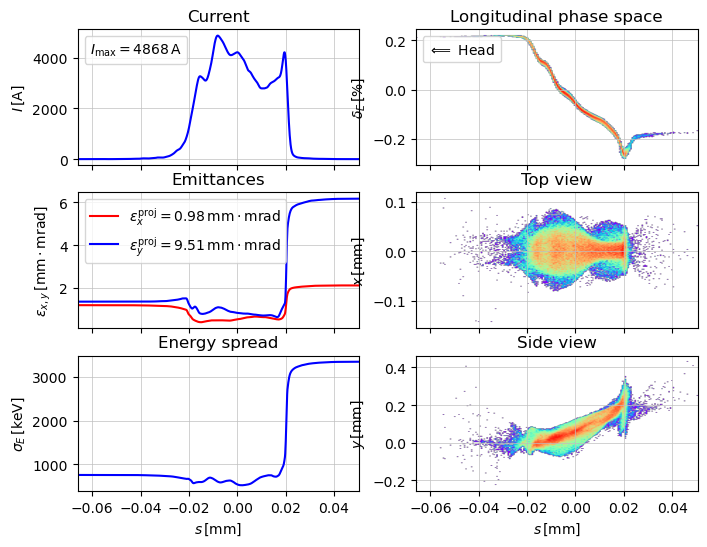

In [12]:
# by default the beam head on the left side
show_e_beam(p_array, figsize=(8,6))
plt.show()

## Crosscheck with analytics: Dipole kick

We are going to crosscheck our current implementation with formulas from [K. Bane, G. Stupakov, and I. Zagorodnov, Wakefields of a Beam near a Single Plate in a Flat Dechirper](https://www.slac.stanford.edu/cgi-wrap/getdoc/slac-pub-16881.pdf):

$$
w_{yd}(s) = \frac{2}{b^3}s_{0yd} \left[ 1 - \left(1 + \sqrt{\frac{s}{s_{0yd}}}\right) e^{- \sqrt{s/s_{0yd}}} \right]
$$
with 
$$
s_{0yd} = 8b^2t/(9\pi \alpha^2 p^2)
$$

Let's take the same parameters from example above: 

Period, p = 0.5 mm

Longitudinal gap, t = 0.25 mm

Distance from the plate, b = 500 $\mu$m

$\alpha = 1 - 0.465 \sqrt{t/p} - 0.07 t/p$


In [13]:
p = 0.5e-3 # period
t = 0.25e-3 # Longitudinal gap
b = 500e-6 # Distance from the plate

alpha = 1 - 0.465 * np.sqrt(t/p) - 0.07 * t/p

print("alpha = ", alpha)
s0 = 8*b**2 * t / (9 * np.pi * alpha**2 * p**2)
print("s0 = ", s0*1e6, " [um]")

alpha =  0.6361953467482554
s0 =  174.765875517375  [um]


### Dipole wake

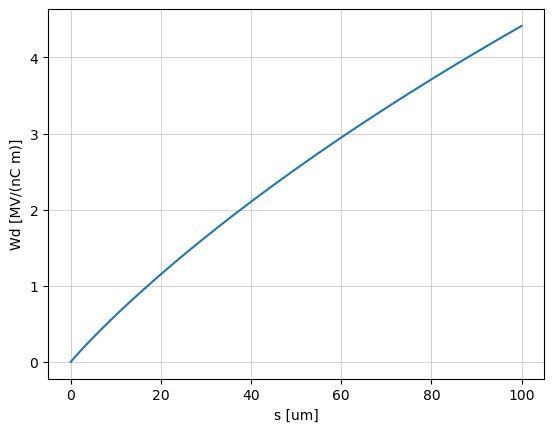

In [14]:
s = np.linspace(0, 100, num=100) *1e-6
w = lambda s: 2./b**3 * s0 * (1 - (1 + np.sqrt(s/s0)) * np.exp(- np.sqrt(s/s0))) * Z0 * speed_of_light / (4 * np.pi) 

MV = 1e6
nC = 1e-9
plt.plot(s*1e6, np.array([w(si) for si in s])*nC/MV )
plt.xlabel("s [um]")
plt.ylabel("Wd [MV/(nC m)]")
plt.show()

#### Convolution wake with the beam current 

In [15]:
def convolve_beam(current, wake):
    """
    convolve wake with beam current

    :param current: current[:, 0] - s in [m], current[:, 1] - current in [A]. The beam head is on the left
    :param wake: wake function in form: wake(s)
    :return: wake_kick[:, 0] - s in [m], wake_kick[:, 1] - V 
    """
    s_shift = current[0, 0]
    current[:, 0] -= s_shift
    s = current[:, 0]

    step = (s[-1] - s[0]) / (len(s) - 1)
    q = current[:, 1] / speed_of_light
    
    w = np.array([wake(si) for si in s])
    
    wake = np.convolve(q, w) * step
    s_new = np.cumsum(np.ones(len(wake))) * step
    wake_kick = np.vstack((s_new, wake))
    return wake_kick.T


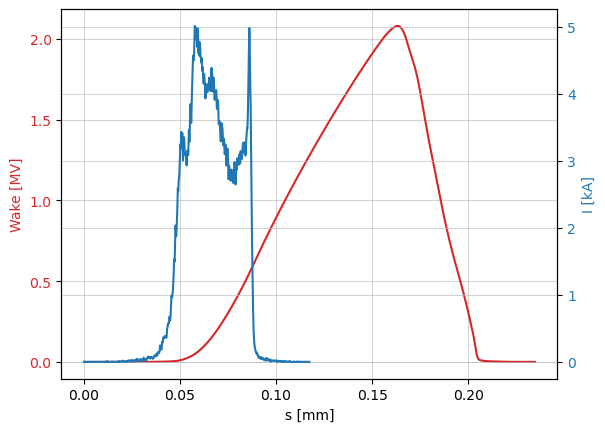

In [16]:
I = s_to_cur(p_array.tau(), 0.01 * np.std(p_array.tau()), np.sum(p_array.q_array), speed_of_light)

dipole_kick = convolve_beam(I, w)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('s [mm]')
ax1.set_ylabel('Wake [MV]', color=color)
ax1.plot(dipole_kick[:, 0] * 1e3, dipole_kick[:, 1] * 1e-6, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('I [kA]', color=color)
ax2.plot(I[:, 0] * 1e3, I[:, 1] * 1e-3, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

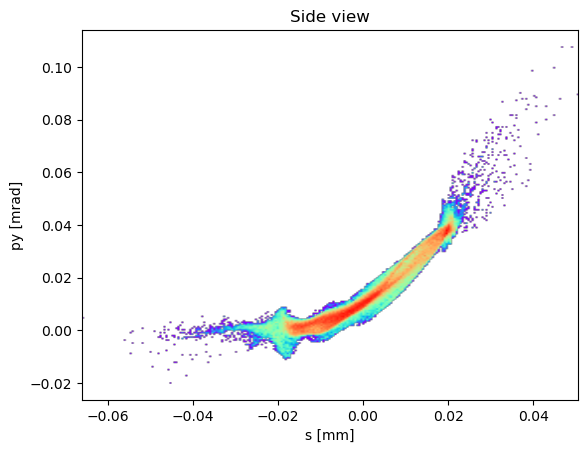

In [17]:
length = 1 # corrugated structure in [m]

p_array = deepcopy(p_array_init)

z = p_array.tau()
ind_z_sort = np.argsort(z)
z_sort = z[ind_z_sort]

wd = np.interp(z_sort - z_sort[0], dipole_kick[:, 0], dipole_kick[:, 1])

delta_E_y =  wd * 1e-9 * length
pc_ref = np.sqrt(p_array.E ** 2 / m_e_GeV ** 2 - 1) * m_e_GeV
delta_py = delta_E_y / pc_ref
p_array.rparticles[3][ind_z_sort] += delta_py

show_density(p_array.tau() * 1e3, p_array.py() * 1e3, ax=None, nbins_x=250, nbins_y=250,
                 interpolation="bilinear", xlabel="s [mm]", ylabel='py [mrad]', nfig=50,
                 title="Side view", figsize=None, grid=False)
plt.show()

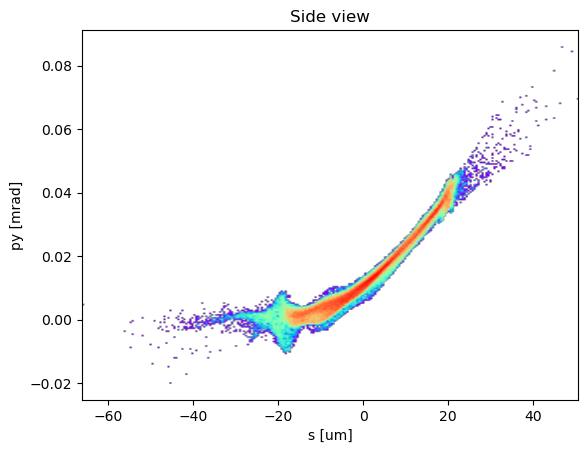

In [18]:
p_array = deepcopy(p_array_init)

wk_tv_kick = WakeTableDechirperOffAxis(b=b,           # distance from the plate in [m]
                                       a=0.01,        # half gap between plates in [m]
                                       width=0.02,    # width of the corrugated structure in [m]
                                       t=t,           # longitudinal gap in [m]
                                       p=p,           # period of corrugation in [m]
                                       length=1,      # length of the corrugated structure in [m]
                                       sigma=12e-6,   # characteristic (rms) longitudinal beam size in [m]
                                       orient="horz") # "horz" or "vert" plate orientation 

# creation of wake object with parameters 
wake = Wake()
# w_sampling - defines the number of the equidistant sampling points for the one-dimensional
# wake coefficients in the Taylor expansion of the 3D wake function.
wake.w_sampling = 500
wake.wake_table = wk_tv_kick
wake.step = 1 # step in Navigator.unit_step, dz = Navigator.unit_step * wake.step [m]

wake.prepare(None)
wake.s_start = 0
wake.s_stop = 1

wake.apply(p_array, dz=1)
show_density(p_array.tau() * 1e6, p_array.py() * 1e3, ax=None, nbins_x=250, nbins_y=250,
                 interpolation="bilinear", xlabel="s [um]", ylabel='py [mrad]', nfig=60,
                 title="Side view", figsize=None, grid=False)
plt.show()